<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-датасета-и-предобработка-данных" data-toc-modified-id="Загрузка-датасета-и-предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка датасета и предобработка данных</a></span></li><li><span><a href="#Подготовка-данных-для-формирования-признаков-для-обучения" data-toc-modified-id="Подготовка-данных-для-формирования-признаков-для-обучения-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных для формирования признаков для обучения</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Мы обучим модель классифицировать комментарии на позитивные и негативные и проверим качество модели при помощи метрики качества *F1*. 

**Мы предпримем следующие шаги**

1. Загрузим и подготовим данные: выполним лемматизацию и токенизацию, очистим массив текстов от стоп-слов.
2. Разобьем выборку на трейновую и валидационную.
3. Векторизуем тексты, чтобы создать набор признаков для модели.
4. Обучим различные модели-классификаторы на трейновой выборке и посчитаем метрику F1 по каждой модели.  
5. Сделаем предсказания на тестовой выборке и посчитаем метрику F1 на ней.



## Подготовка

In [1]:
import re
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords 

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

### Загрузка датасета и предобработка данных

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [3]:
data = data.drop('Unnamed: 0', axis =1)

Оценим баланс классов - это важно для того, чтобы модель умела одинаково хорошо предсказывать как положительный, так и отрицательный (нулевой) класс.

In [4]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

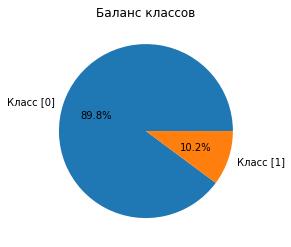

In [5]:
data['toxic'].value_counts(normalize=True).plot(kind='pie', 
                                                legend=False, 
                                                autopct='%1.1f%%',
                                                labels=['Класс [0]','Класс [1]'])
plt.title('Баланс классов')
plt.ylabel('')
plt.show()

Дисбаланс классов в сторону класса 0 в соотношении 9:1. Это может помешать модели правильно классифицировать классы с меньшим процентом. <br>
Необходимо произвести балансировку классов. Поскольку у нас большая и "тяжелая" выборка, мы можем воспользоваться методом даунсемплинга, чтобы одновременно проредить класс 0 и снизить размерность датасета, чтобы модели было легче его обрабатывать. <br>
Создадим функцию, которая производит балансировку, а после - применим ее на трейновой выборке.

In [6]:
def balancing_classes(features, target, frac):    
    class_0 = target[target==0]
    class_1 = target[target==1]
    class_0_downsampled = class_0.sample(frac=frac, random_state=12345)
    target_down = pd.concat([class_0_downsampled, class_1])
    features_down = features[target_down.index]
    target_down.value_counts(normalize=True).plot(kind='pie', 
                                                    legend=False, 
                                                    autopct='%1.1f%%',
                                                    labels=['Класс [0]','Класс [1]'])
    plt.title('Баланс классов')
    plt.ylabel('');
    print('Длина выборки:', features_down.shape[0])
    return features_down, target_down

### Подготовка данных для формирования признаков для обучения

Нам необходимо подготовить признаки для их использования в модели. При прогнозировании тональности текста нам необходимо будет анализировать вектора слов, а для этого необходимо очистить и лемматизировать тексты. Создадим для этого функцию.

In [7]:
nltk.download('averaged_perceptron_tagger')
# функция создания pos тэгов
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

l = WordNetLemmatizer()
# функция лемматизации и очистки текста
def lemm_and_clear(corpus):
    lemm_corpus = []
    for w in nltk.word_tokenize(corpus):
        lemm_corpus.append(l.lemmatize(w, get_wordnet_pos(w)))
    text = " ".join(lemm_corpus)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    
    return " ".join(text.split())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
%%time
data['lemm_clear_text'] = data['text'].apply(lemm_and_clear)
data.head()

CPU times: user 19min 22s, sys: 1min 56s, total: 21min 18s
Wall time: 21min 19s


,text,toxic,lemm_clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n t make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


Для эффективного использования времени работы системы сделаем предобработку текстовых данных (лемматизацию, очистку и т.д.) уже на отбалансированных данных трейновой выборки, она в 8 раз меньше по размеру и обрабатывается быстрее. <br>
Поэтому мы сразу разобьем выборку на трейновую, валидационную и тестовую, трейновую отбалансируем и после этого применим функцию очистки. Поскольку это еще не финальные признаки для модели, сохраним их в переменной *raw_features*.

Длина выборки: 21564


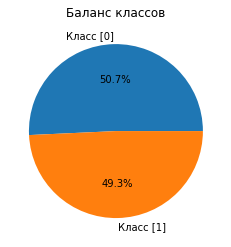

In [9]:
raw_features = data['lemm_clear_text']
target = data['toxic']
raw_features_trainval, raw_features_test, target_trainval, target_test = train_test_split(raw_features, 
                                                                            target, 
                                                                            test_size = 0.25, 
                                                                            random_state = 12345)

raw_features_train, raw_features_val, target_train, target_val = train_test_split(raw_features_trainval, 
                                                                                                target_trainval, 
                                                                                                test_size = 0.1, 
                                                                                                random_state = 12345)

raw_features_train_down, target_train = balancing_classes(raw_features_train, target_train, 0.11)
plt.show()


In [10]:
raw_features_train_down = pd.DataFrame(data =raw_features_train_down, columns = ['lemm_clear_text'], index = raw_features_train_down.index)
raw_features_val = pd.DataFrame(data =raw_features_val, columns = ['lemm_clear_text'], index = raw_features_val.index)
raw_features_test = pd.DataFrame(data =raw_features_test, columns = ['lemm_clear_text'], index = raw_features_test.index)
raw_features_trainval = pd.DataFrame(data =raw_features_trainval, columns = ['lemm_clear_text'], index = raw_features_trainval.index)

Мы предобработали текстовый массив данных, так что он теперь готов к векторизации - созданию признаков для обучения моделей.

## Обучение

Для того, чтобы создать признаки, мы произведем векторизацию данных, предварительно очистив корпус от стоп-слов, которые не несут для модели никакой смысловой нагрузки.

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
 

stopWords = set(stopwords.words('english'))
def stopwords_token(df):
    words = word_tokenize(df)
    wordsFiltered = []

    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    wordsFiltered = " ".join(wordsFiltered)
    return wordsFiltered

raw_features_train_down['pure_text'] = raw_features_train_down['lemm_clear_text'].apply(stopwords_token)
raw_features_val['pure_text'] = raw_features_val['lemm_clear_text'].apply(stopwords_token)
raw_features_trainval['pure_text'] = raw_features_trainval['lemm_clear_text'].apply(stopwords_token)
raw_features_test['pure_text'] = raw_features_test['lemm_clear_text'].apply(stopwords_token)

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words, analyzer='word') 
count_tf_idf.fit(raw_features_train_down['pure_text'])
features_train = count_tf_idf.transform(raw_features_train_down['pure_text'])
features_val = count_tf_idf.transform(raw_features_val['pure_text'])
features_trainval = count_tf_idf.transform(raw_features_trainval['pure_text'])
features_test = count_tf_idf.transform(raw_features_test['pure_text'])
features_test.shape


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(39823, 44334)

Мы сохранили векторизованные данные в переменную features, а целевой признак - столбец toxic - в переменную target.<br>
Теперь все готово к обучению различных моделей. <br>
Для референса создадим dummy модель, делающее рандомные предсказания класса, и проверим, какая у нее F1 мера. Наша цель - показатель метрики не менее 0,75.

In [15]:
# Dummy model
dummy_predict = np.random.randint(0, 2, target_test.shape[0])
print('F1-мера на Dummy модели:', round(f1_score(target_test, dummy_predict), 3))

F1-мера на Dummy модели: 0.166


Предсказуемо Dummy модель не дает высокий результат. Теперь обучим модели логистической регрессии, дерево и лес, а также градиентный бустер, и посмотрим, какие результаты дадут нам эти модели.

***Logistic regression***

In [16]:
model_LOG = LogisticRegression()
model_LOG.fit(features_train, target_train)
predict_LOG = model_LOG.predict(features_val)
f1_LOG = f1_score(target_val, predict_LOG)

***Decision Tree***

In [17]:
model_DT = DecisionTreeClassifier()
model_DT.fit(features_train, target_train)
predict_DT = model_DT.predict(features_val)
f1_DT = f1_score(target_val, predict_DT)

***Gradient Boosting***

In [18]:
model_GBC = GradientBoostingClassifier()
model_GBC.fit(features_train, target_train)
predict_GBC = model_GBC.predict(features_val)
f1_GBC = f1_score(target_val, predict_GBC)

***Random Forest***

In [19]:
model_RFC = RandomForestClassifier()
model_RFC.fit(features_train, target_train)
predict_RFC = model_RFC.predict(features_val)
f1_RFC = f1_score(target_val, predict_RFC)

Соберем все данные в таблицу и оценим результаты.

In [20]:
table = pd.DataFrame(index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Booster'],
                    columns = ['F1'])
table.loc['Logistic Regression'] = f1_LOG
table.loc['Decision Tree'] = f1_DT
table.loc['Random Forest'] = f1_RFC
table.loc['Gradient Booster'] = f1_GBC
table

,F1
Logistic Regression,0.656651
Decision Tree,0.482615
Random Forest,0.622889
Gradient Booster,0.651093


Логистическая регрессия дала наилучший результат - 0,66. Это недостаточно, но лучше чем у остальных моделей. Проверим, какой результат она даст на тестовой выборке. <br>
Обучим модель уже на полных данных трейновой и валидационной выборок.

In [21]:
model_LOG.fit(features_trainval, target_trainval)
print('F1-мера на тестовой выборке:', round(f1_score(target_test, model_LOG.predict(features_test)),3))

F1-мера на тестовой выборке: 0.721


Посмотрим на графике ROC-AUC, как распределяются правильные положительные ответы.

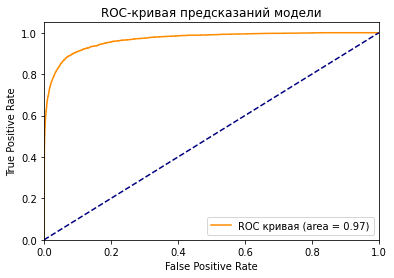

In [22]:
predict_probs = model_LOG.predict_proba(features_test)
predict_probs = predict_probs[:, 1]
lr_auc = roc_auc_score(target_test, predict_probs)
fpr, tpr, treshold = roc_curve(target_test, predict_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая предсказаний модели')
plt.legend(loc="lower right")
plt.show()

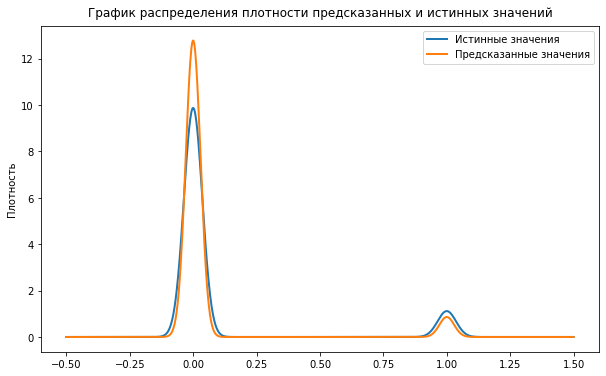

In [23]:
f1 = f1_score(target_test, model_LOG.predict(features_test))
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(model_LOG.predict(features_test)).plot(kind='kde', linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

Мы видим на графике, что модель слишком "оптимистична" и плохо предсказывает класс 1, то есть больше твитов классифицирует как нетоксичные. Постараемся это исправить подбором гиперпараметров.

In [25]:
warnings.filterwarnings('ignore')

best_f1 = 0
best_c = 0
best_iter = 0
for c in range(10, 21, 2):
    for max_iter in range(1, 17, 2):
        model = LogisticRegression(random_state=12345, solver='sag', C = c, max_iter = max_iter)
        model.fit(features_train, target_train)
        predict = model.predict(features_val)
        f1 = f1_score(target_val, predict)
        if f1> best_f1:
            best_f1 = f1
            best_c = c
            best_iter = max_iter
            
print(f'Наилучший показатель метрики f1 {f1:.3f} достигается при С = {c} и кол-ве итераций = {max_iter}')

Наилучший показатель метрики f1 0.660 достигается при С = 20 и кол-ве итераций = 15


Посмотрим, как работает такая модель на тестовой выборке.

In [26]:
model = LogisticRegression(random_state=12345, solver='sag', C = 20, max_iter = 15)
model.fit(features_trainval, target_trainval)
print(f'F1 на тестовой выборке с оптимальными гиперпараметрами: {f1_score(target_test, model.predict(features_test)) : .3f}')

F1 на тестовой выборке с оптимальными гиперпараметрами:  0.773


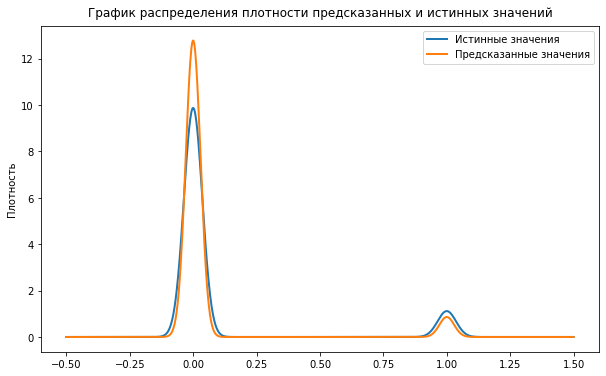

In [27]:
f1 = f1_score(target_test, model_LOG.predict(features_test))
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(model_LOG.predict(features_test)).plot(kind='kde', linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

Модель по-прежнему плохо предсказывает класс 1, хотя показатель метрики даже выше, чем при валидации. Видимо, это достигается засчет высокого показателя регуляризации ("С") = модель не переобучается на трейне. <br>
Полученная метрика выше порога в 0,75, то есть удовлетворяет условиям заказчика. Однако можно попробовать еще улучшить метрику, сдвинув порог классификации токсичных твитов методом подбора порога вероятности.<br>
Поскольку при базовом пороге 0,5 недостаточное количество твитов классифицируется как токсичные (класс [1]), то установим более высокий порог - в промежутке от 0,1 до 0,4.

In [28]:
model.fit(features_train, target_train)
probabilities=model.predict_proba(features_val)
probabilities_one = probabilities[:, 1]
best_threshold = 0
best_f1 = 0

for threshold in np.arange(0.1, 0.4, 0.04):
    predicted_v = probabilities_one > threshold
    f1 = f1_score(target_val, predicted_v)
    if f1> best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Наилучший результат метрики F1 достигается при пороге = {best_threshold :.2f}")


Наилучший результат метрики F1 достигается при пороге = 0.38


Теперь посмотрим, как работает этот порог на тестовой выборке.

## Выводы

Мы сумели обработать размеченные текстовые сообщения с оценкой токсичности сообщений, и обучить несколько моделей - Логистическую регрессию, Дерево решений, Случайный лес, а также Градиентный бустинг, для того, чтобы выбрать наиболее эффективную модель. <br>
Для лучшего результата мы сбалансировали классы методом даунсемплинга. <br>
В результате ***логистическая регрессия*** проявила себя наиболее эффективной на трейновой выборке и после подбора гиперпараметров нам удалось достигнуть F1-меры в 0,77. <br>
Посмотрим, как ведет себя модель на тестовой выборке при тех же условиях.

In [29]:
model = LogisticRegression(random_state=12345, solver='sag', C = 15, max_iter = 15)
model.fit(features_trainval, target_trainval)
probabilities=model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
predicted = probabilities_one > 0.38
f1 = f1_score(target_test, predicted)
print(f'F1-мера с порогом вероятности 0.38: {f1: .2}')

F1-мера с порогом вероятности 0.38:  0.78


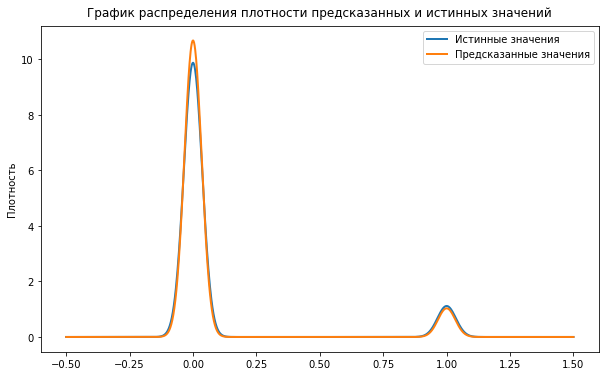

In [30]:
predicted = predicted.astype('int')
f1 = f1_score(target_test, predicted)
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(predicted).plot(kind='kde', linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

На графике мы видим, что модель уже намного лучше предсказывает нулевой класс. Эффективность модели на высоком уровне - F1-мера равна 0,78.